# k-NN


In this demo we're going to see the k-Nearest Neighbours algorithm, a non-linear distance-based ML model, and we'll see both its regressor and classifier variants.


In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt

Let's say we want to predict the daily price movements of Apple stock. The target is 1-day returns for regression and the direction of 1-day returns for classification. For features we'll engineer some features like lagged returns and technical indicators from historical data.  
Obviously this is an extremely simplistic model and probably won't perform better than chance but our main aim here is to demonstrate how k-NN works.

In [3]:
data = yf.download("AAPL", start="2004-01-01", end="2024-01-01")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,0.384821,0.388393,0.378214,0.380000,0.320901,144642400
2004-01-05,0.382500,0.399821,0.382500,0.395893,0.334322,395018400
2004-01-06,0.397321,0.400357,0.387679,0.394464,0.333115,509348000
2004-01-07,0.394643,0.407679,0.391607,0.403393,0.340655,586874400
2004-01-08,0.407857,0.423750,0.404464,0.417143,0.352267,460303200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868134,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700


The columns are multiindex (see how they have two "levels"). I'll make `Date` a regular columna and then flatten the dataframe by resetting the index.


In [4]:
data["Date"] = data.index
data.reset_index(drop=True, inplace=True)

In [5]:
data

,Open,High,Low,Close,Adj Close,Volume,Date
0,0.384821,0.388393,0.378214,0.380000,0.320901,144642400,2004-01-02
1,0.382500,0.399821,0.382500,0.395893,0.334322,395018400,2004-01-05
2,0.397321,0.400357,0.387679,0.394464,0.333115,509348000,2004-01-06
3,0.394643,0.407679,0.391607,0.403393,0.340655,586874400,2004-01-07
4,0.407857,0.423750,0.404464,0.417143,0.352267,460303200,2004-01-08
...,...,...,...,...,...,...,...
5028,195.179993,195.410004,192.970001,193.600006,192.868134,37122800,2023-12-22
5029,193.610001,193.889999,192.830002,193.050003,192.320221,28919300,2023-12-26
5030,192.490005,193.500000,191.089996,193.149994,192.419830,48087700,2023-12-27
5031,194.139999,194.660004,193.169998,193.580002,192.848221,34049900,2023-12-28


Let's engineer some features...


In [6]:
# Engineer feature: 1-day lagged returns
data["1d_Prev_Adj_Close"] = data["Adj Close"].shift(1)
data["1d_Lagged_Return"] = (data["Adj Close"] - data["1d_Prev_Adj_Close"]) / data["1d_Prev_Adj_Close"]

# Engineer feature: 5-day lagged returns
data["5d_Prev_Adj_Close"] = data["Adj Close"].shift(5)
data["5d_Lagged_Return"] = (data["Adj Close"] - data["5d_Prev_Adj_Close"]) / data["5d_Prev_Adj_Close"]

# Engineer feature: 20-day lagged returns
data["20d_Prev_Adj_Close"] = data["Adj Close"].shift(20)
data["20d_Lagged_Return"] = (data["Adj Close"] - data["20d_Prev_Adj_Close"]) / data["20d_Prev_Adj_Close"]

# Engineer feature: RSI
def calculate_rsi(data, window_length):
    delta = data["Adj Close"].diff()
    avg_gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
    avg_loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
data["RSI"] = calculate_rsi(data, 14)


Let's create our numerical target for regression and categorical "Up/Down" target for classification. Again, this is too simplistic and you wouldn't want to trade on the signals generated by such a model. This is all just for illustrating k-NNs.

In [7]:
# Engineer target for regression: 1-day future returns
data["1d_Future_Adj_Close"] = data["Adj Close"].shift(-1)
data["1d_Future_Return"] = (data["1d_Future_Adj_Close"] - data["Adj Close"]) / data["Adj Close"]

# Engineer target for classification: whether or not the 1-day future return is positive
data["1d_Future_Return_Positive"] = (data["1d_Future_Return"] > 0).astype(int)

# These will have created some NaNs, so let's get rid of those
data = data.dropna()

And specify our feature and target columns.

In [8]:
X = data[["1d_Lagged_Return", "5d_Lagged_Return", "20d_Lagged_Return", "RSI"]]
y_reg = data["1d_Future_Return"]
y_clf = data["1d_Future_Return_Positive"]

Split the data into training and test sets... Let's say 80-20.

In [9]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42, shuffle=False)
# X_train.shape, X_test.shape, y_reg_train.shape, y_reg_test.shape, y_clf_train.shape, y_clf_test.shape

**Remember:** k-NN is a distance-based algorithm so it's imperative that we scale our features, and we always do so after the split.

In [10]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We're ready to train a model with this data.

In [11]:
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train_reg)

KNeighborsRegressor()

In [12]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train_clf)

KNeighborsClassifier()

Let's take a look at the cross-validated scores and learning curves...

In [19]:
cv_scores_reg = cross_val_score(knn_reg, X_train, y_train_reg, cv=5, scoring='r2')
mean_cv_score_reg = np.mean(-cv_scores_reg)
print(f'Cross-Validated R-Squared: {mean_cv_score_reg:.2f}')

y_pred_reg = knn_reg.predict(X_test)
test_r2 = r2_score(y_test_reg, y_pred_reg)
print(f'Test R-Squared: {test_r2:.2f}')

Cross-Validated R-Squared: 0.24
Test R-Squared: -0.16


In [14]:
cv_scores_clf = cross_val_score(knn_clf, X_train, y_train_clf, cv=5, scoring='accuracy')
mean_cv_score_clf = np.mean(cv_scores_clf)
print(f'Cross-Validated Accuracy: {mean_cv_score_clf:.2f}')

y_pred_clf = knn_clf.predict(X_test)
test_acc = accuracy_score(y_test_clf, y_pred_clf)
print(f'Test Accuracy: {test_acc:.2f}')

Cross-Validated Accuracy: 0.52
Test Accuracy: 0.51


Although the focus of this demo is k-NN models, I'd like to show you an example of how we can plot learning curves with scikit-learn and matplotlib. Let's draw the learning curves for both models...

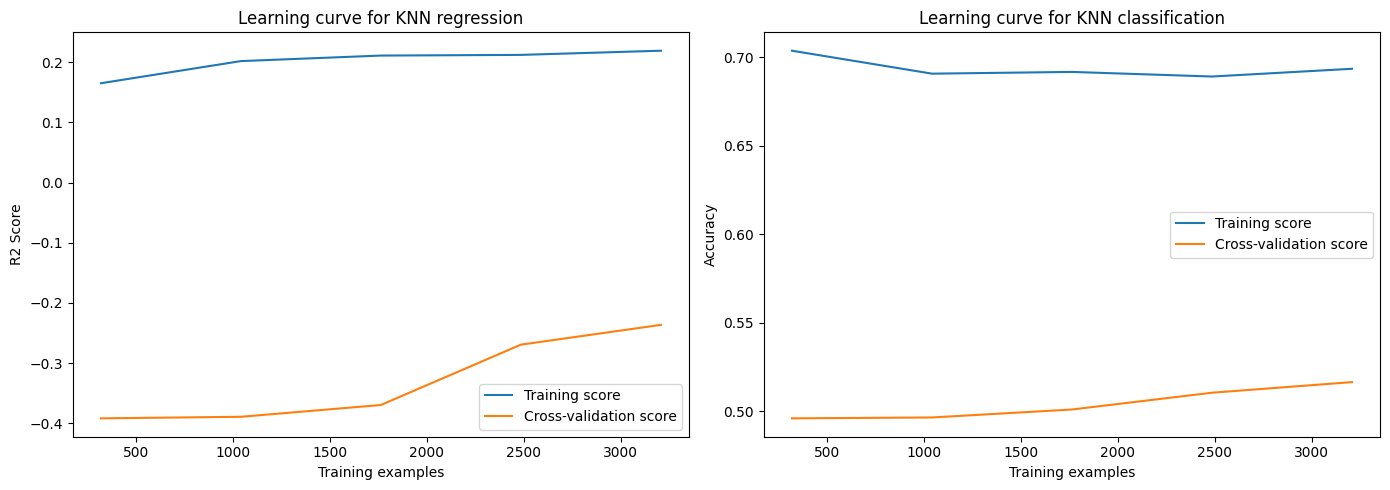

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Learning curves for the regression model
train_sizes, train_scores, test_scores = learning_curve(knn_reg, X_train, y_train_reg, cv=5, scoring="r2")
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
axes[0].plot(train_sizes, train_scores_mean, label='Training score')
axes[0].plot(train_sizes, test_scores_mean, label='Cross-validation score')
axes[0].set_title('Learning curve for KNN regression')
axes[0].set_xlabel('Training examples')
axes[0].set_ylabel('R2 Score')
axes[0].legend()

# Learning curves for the classification model
train_sizes_clf, train_scores_clf, test_scores_clf = learning_curve(knn_clf, X_train, y_train_clf, cv=5, scoring="accuracy")
train_scores_mean_clf = np.mean(train_scores_clf, axis=1)
test_scores_mean_clf = np.mean(test_scores_clf, axis=1)
axes[1].plot(train_sizes_clf, train_scores_mean_clf, label='Training score')
axes[1].plot(train_sizes_clf, test_scores_mean_clf, label='Cross-validation score')
axes[1].set_title('Learning curve for KNN classification')
axes[1].set_xlabel('Training examples')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()